In [8]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
import logging

import numpy as np
from scipy import ndimage
from skimage import morphology
from skimage import segmentation
from skimage.feature import peak_local_max
from skimage.exposure import equalize_adapthist
from skimage.exposure import rescale_intensity
from skimage.measure import label
import os

from PIL import Image 
from scipy import signal
import cv2

import numpy as np

import imageio
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import os
import skimage.io as skio
import numpy as np 
import matplotlib.image as mpimg
from math import nan 


import numpy as np
import logging
import skimage.io as skio
import matplotlib.pyplot as plt
import cv2

In [9]:
def histogram_normalization(image, kernel_size=None):
    """Pre-process images using Contrast Limited Adaptive
    Histogram Equalization (CLAHE).

    If one of the inputs is a constant-value array, it will
    be normalized as an array of all zeros of the same shape.

    Args:
        image (numpy.array): numpy array of phase image data.
        kernel_size (integer): Size of kernel for CLAHE,
            defaults to 1/8 of image size.

    Returns:
        numpy.array: Pre-processed image data with dtype float32.
    """
    if not np.issubdtype(image.dtype, np.floating):
        logging.info('Converting image dtype to float')
    image = image.astype('float32')

    for batch in range(image.shape[0]):
        for channel in range(image.shape[-1]):
            X = image[batch, ..., channel]
            sample_value = X[(0,) * X.ndim]
            if (X == sample_value).all():
                # TODO: Deal with constant value arrays
                # https://github.com/scikit-image/scikit-image/issues/4596
                logging.warning('Found constant value array in batch %s and '
                                'channel %s. Normalizing as zeros.',
                                batch, channel)
                image[batch, ..., channel] = np.zeros_like(X)
                continue

            # X = rescale_intensity(X, out_range='float')
            X = rescale_intensity(X, out_range=(0.0, 1.0))
            X = equalize_adapthist(X, kernel_size=kernel_size)
            image[batch, ..., channel] = X
    return image

In [10]:

# 腐蚀操作
def grayscale_erosion(image, structuring_element):

    for batch in range(image.shape[0]):
        for channel in range(image.shape[-1]):
            X = image[batch, ..., channel]
            h, w = X.shape
            h_se, w_se = structuring_element.shape
            eroded_image = np.zeros_like(X)
            for i in range(h):
                for j in range(w):
                    min_value = float('inf')  # 初始化为无穷大，确保会被任何像素值取代

                    # 遍历结构元素的所有像素
                    for m in range(h_se):
                        for n in range(w_se):
                            if structuring_element[m, n] == 1:
                                # 边界处理，如果越界则忽略该像素
                                if i + m >= 0 and i + m < h and j + n >= 0 and j + n < w:
                                    current_value = X[i + m, j + n]
                                    min_value = min(min_value, current_value)

            eroded_image[i, j] = min_value
            image[batch, ..., channel] = eroded_image
    return image

In [11]:

#边缘检测操作
def edge_enhancement(input_image):
    # 定义Sobel算子
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    # 计算图像梯度
    gradient_x = cv2.filter2D(input_image, -1, sobel_x)
    gradient_y = cv2.filter2D(input_image, -1, sobel_y)

    # 计算梯度幅值
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

    # 边缘增强
    enhanced_image = input_image + gradient_magnitude

    return enhanced_image




In [12]:
#canny边缘增强
def edge_enhancement_canny(image, threshold1, threshold2):
    for batch in range(image.shape[0]):
        for channel in range(image.shape[-1]):
            X = image[batch, ..., channel]
             # 边缘检测
            edges = cv2.Canny(X, threshold1, threshold2)

            # 边缘增强
            enhanced_image = X + 2*edges
            image[batch, ..., channel] = enhanced_image
    
    # # 边缘检测
    # edges = cv2.Canny(input_image, threshold1, threshold2)

    # # 边缘增强
    # enhanced_image = input_image + edges

    return image

# # 设置Canny算法的阈值
# threshold1 = 100
# threshold2 = 200

# # 边缘增强
# enhanced_image = edge_enhancement_canny(input_image, threshold1, threshold2)


In [13]:
# 步骤一 进口轮子 编写函数


# 加载函数
# 去掉高于平均背景水平的像素
def background_noise(image,noise_level= 174):
    if not np.issubdtype(image.dtype, np.floating):
        logging.info('Converting image dtype to float')
    image = image.astype('float32')

    for batch in range(image.shape[0]):
        for channel in range(image.shape[-1]):
            img = image[batch, ..., channel]
            # img[img<noise_level] = noise_level
            img[img<noise_level] = 0
            image[batch, ..., channel] = img
    return image
# 均值滤波
def blur_proc(image):
    if not np.issubdtype(image.dtype, np.floating):
        logging.info('Converting image dtype to float')
    image = image.astype('float32')

    for batch in range(image.shape[0]):
        for channel in range(image.shape[-1]):
            img = image[batch, ..., channel]
            normal_image = cv2.blur(img,(20,20))
            image[batch, ..., channel] = normal_image
    return image

def remove_hight_variance_pixels(image):
    for batch in range(image.shape[0]):
        for channel in range(image.shape[-1]):
            img = image[batch, ..., channel]
            max_intensity = 20*img.mean()
            img[img>max_intensity] = 0
            image[batch, ..., channel] = img
    return image

#均衡化
def his(image):


    for batch in range(image.shape[0]):
        for channel in range(image.shape[-1]):
            img = image[batch, ..., channel]
            normal_image = cv2.equalizeHist(img)
            image[batch, ..., channel] = normal_image
    return image

def float32_to_uint8(float_value):
    # 将float32的值限制在0到1之间
    # float_value = np.clip(float_value, 0.0, 1.0)
    
    # # 将float32乘以255，并进行舍入
    # uint8_value = np.round(float_value * 255.0, decimals=0).astype(np.uint8)
    
    scaled_image = (float_value - np.min(float_value)) / (np.max(float_value) - np.min(float_value))
    uint8_value = np.round(scaled_image * 255.0).astype(np.uint8)

    return uint8_value


def uint8_to_uint16(uint8_array):
    # 将float32的值限制在0到1之间
    # float_value = np.clip(float_value, 0.0, 1.0)
    
    # # 将float32乘以255，并进行舍入
    # uint8_value = np.round(float_value * 255.0, decimals=0).astype(np.uint8)
        
    scaled_array = (uint8_array.astype(np.float32) / 255.0) * 65535.0
    uint16_array = scaled_array.astype(np.uint16)

    return uint16_array


def uint16_to_uint8(uint16_array):
    # 将uint16数组转换为uint8数组
    uint8_array = (uint16_array / 65535.0 * 255).astype(np.uint8)
    return uint8_array


def adaptive_threshold_enhancement(image):
    # 自适应阈值处理
    thresholded = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    return thresholded

def contrast_enhancement(image):
    # 局部对比度增强 (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(image)
    return enhanced

def process_frame(image):

    for batch in range(image.shape[0]):
        for channel in range(image.shape[-1]):
            img = image[batch, ..., channel]
            # 自适应阈值处理
            thresholded = adaptive_threshold_enhancement(img)
            # 局部对比度增强
            enhanced = contrast_enhancement(thresholded)
            image[batch, ..., channel] = enhanced
    return image
    


def average_intensity(image):
    intensity_sum = 0
    mean_intensity = 0

    # 计算图像集合的总强度
    for batch in range(image.shape[0]):
        for channel in range(image.shape[-1]):
            img = image[batch, ..., channel]
            intensity_sum += np.mean(img)
    
    mean_intensity = intensity_sum / (image.shape[0] * image.shape[-1])

    # 根据平均强度进行像素强度调整
    for batch in range(image.shape[0]):
        for channel in range(image.shape[-1]):
            img = image[batch, ..., channel]
            intensity_local = np.mean(img)
            if intensity_local < mean_intensity:
                img_diff = mean_intensity - intensity_local
                img = img + img_diff
            if intensity_local > mean_intensity:
                img_diff = intensity_local - mean_intensity
                img = img - img_diff
            image[batch, ..., channel] = img

    return image



In [14]:
root_path = r'/data/sunrui/celldata/20231018-SOX2-CELLID-A/1SOX2-CELLID-A/'
file_name = r'1SOX2-CELLID-A.tif'

img_raw = skio.imread(root_path +'/01/'+ file_name, plugin="tifffile")
# img_raw = skio.imread(root_path + file_name, plugin="tifffile")
# print(img_raw.shape)


#读取一系列图像

# root_path = r'/data/sunrui/celldata/20230824_HBEC_test_DL/10%Laser_300ms_1x1bin/'
# raw_path = root_path#原始图像路径
# imgfiles = [os.path.join(raw_path, f) for f in os.listdir(raw_path) if f.endswith('.tif') or f.endswith('.tiff')]
# imgfiles.sort()

# img_raw = []
# print(len(imgfiles))
# for i in range(len(imgfiles)):
#     img_raw.append(skio.imread(imgfiles[i]).astype(np.uint16))
print(len(img_raw))
img_raw = np.array(img_raw)
print(img_raw.shape)
print(img_raw.shape[0])

315
(315, 1000, 1000)
315


In [15]:
# plt.imshow(img_raw[2])
# x = img_raw[2]
# print(x.mean())
# print(x.max())
# print(x.sort)

# y = img_raw[2]
# print(y.mean())
# print(y.max())
# print(y.sort)
# plt.show()

In [16]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 假设 img_raw 是图像数据

# plt.subplot(2, 2, 1)
# plt.imshow(img_raw[1])
# x = img_raw[1]
# print("Mean of x:", x.mean())
# print("Max of x:", x.max())

# plt.subplot(2, 2, 2)
# plt.imshow(img_raw[2])
# y = img_raw[2]
# print("Mean of y:", y.mean())
# print("Max of y:", y.max())
# y = remove_hight_variance_pixels(img_raw)
# # max_row, max_col = np.where(y == y.max())
# # print(max_col)
# # print(max_row)
# # plt.plot(max_col, max_row, 'ro')  # 绘制最大值位置的红色圆点

# # plt.subplot(2, 2, 4)
# # plt.imshow(img_raw[2])
# # y.sort()  # 对数组 y 进行排序
# # print("Sorted y:", y)
# plt.show()


In [17]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 生成一个随机图像作为示例
# image = img_raw[2]

# # 找到最大灰度值的位置
# max_row, max_col = np.unravel_index(np.argmax(image), image.shape)

# # 显示图像和最大值点
# plt.imshow(image, cmap='gray')
# plt.scatter(max_col, max_row, c='red', marker='o', s=50, label='Max Value')
# plt.legend()
# plt.show()

# print("Max Gray Value:", image[max_row, max_col])
# print("Max Value Location (Row, Col):", max_row, max_col)


(315, 1000, 1000)
x:
(315, 1000, 1000, 1)
uint16
.............................
(315, 1000, 1000, 1)
float32
img_pre_save:
float32
(315, 1000, 1000, 1)
uint8
(315, 1000, 1000, 1)


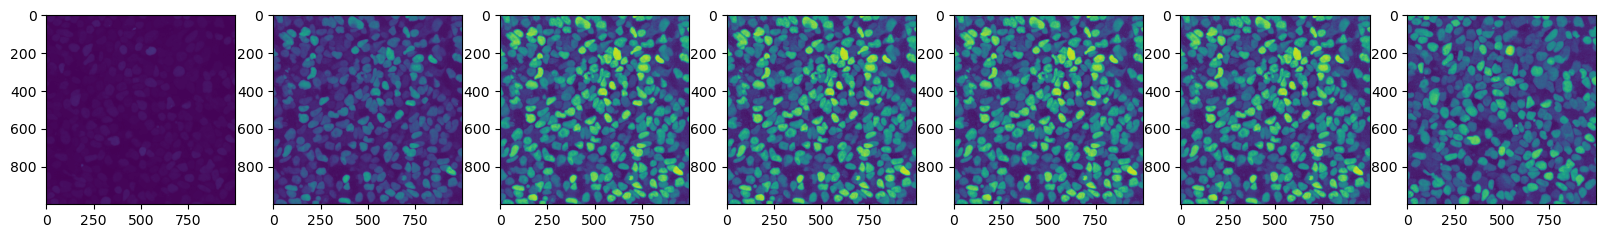

In [18]:
# 步骤二
# 一次走完流程
# 加载图片 Load Image (single)
# x = skio.imread('D:\/new_folder\human_f01_stack\max_human_stack_30_100.tif', plugin="tifffile")
#file_name = 'r07c05f02.tif kept stack.tif'
# x = skio.imread(r'D:\new_folder\deepcell-tf-master\mySegment\100 slices\/'+file_name, plugin="tifffile")
#x = skio.imread(r'D:\new_folder\deepcell-tf-master\my_post_process\new_cell_hesc\r06c02f01-ch1.tif', plugin="tifffile")

# root_path = r'/data/sunrui/celldata/r03c03f01/'
# file_name = r'r03c03f01.tif'

# x = skio.imread(root_path + file_name, plugin="tifffile")
# print(x.shape)


# x = skio.imread(r'/data/sunrui/celldata/20230414_hesc_Mixl1_yy/r03c03f01/r03c03f01.tif',plugin="tifffile")
# print(x.shape)
# x = np.expand_dims(x,axis=3)
# # x = np.expand_dims(x,axis=3)
# print(x.dtype)
plt.figure(figsize=(20, 30))

x = img_raw.copy()
print(x.shape)
x = np.expand_dims(x,axis=3)
print('x:')
print(x.shape)
print(x.dtype)
print('.............................')
# x = x[1:20,:,:,:]
plt.subplot(1,7,1)
plt.imshow(x[0,...,0])

batch = 50
total_frames = x.shape[0]
# total_frames = 50
img_pre_save = np.zeros(x.shape,dtype='float32')
print(img_pre_save.shape)
print(img_pre_save.dtype)
# x = x.astype('uint8')
# img_pre = background_noise(x)
# img_pre = blur_proc(img_pre)
# img_pre = his(x)
# img_pre = his(x)
#直方图均衡化
# img_pre=histogram_normalization(x)
# print('histogram_normalization DONE!')
#腐蚀操作
# structuring_element = np.ones((3, 3), np.uint8)
# img_pre = grayscale_erosion(img_pre, structuring_element)
# print('grayscale_erosion DONE!')
#Canny边缘检测



## 用于常规图像处理
for i in range(0, total_frames, batch):
    # mean_intensity = 0
    img_raw0 = x[i:i+batch,:,:,:]
    # img_raw = x[1:10,:,:]
    # print(i)
    # print('img_raw:')
    # print(img_raw.dtype)
    # print(img_raw.shape)
    plt.subplot(1,7,2)
    plt.imshow(img_raw0[0,...,0])  
    # print('.....................')


    img_pre = img_raw0

    img_pre = remove_hight_variance_pixels(img_pre)
    img_pre = histogram_normalization(img_pre)
    # print('histogram_normalization DONE!')
    # print('img_his:')
    # print(img_pre.dtype)
    # print(img_pre.shape)
    plt.subplot(1,7,3)
    plt.imshow(img_pre[0,...,0])  
    # print('.....................')

    # img_pre = (img_pre * 255).astype(np.uint8)
    img_pre = float32_to_uint8(img_pre)
    threshold1 = 100
    threshold2 = 200
    # print('img_32_TO_8:')
    # print(img_pre.shape)
    # print(img_pre.dtype)
    # print('.....................')

    img_pre = edge_enhancement_canny(img_pre, threshold1, threshold2)
    # print('img_edge_enhance:')
    # print(img_pre.dtype)
    # print(img_pre.shape)
    # img_pre=process_frame(img_pre)
    plt.subplot(1,7,4)
    plt.imshow(img_pre[0,...,0])  
    # print('.....................')

    img_pre = uint8_to_uint16(img_pre)
    # print('img_8_TO_16:')
    # print(img_pre.dtype)
    # print(img_pre.shape)
    # print('.....................')
    
    img_pre = background_noise(img_pre)
    # print('img_backgroundNoise:')
    # print(img_pre.dtype)
    # print(img_pre.shape)
    plt.subplot(1,7,5)
    plt.imshow(img_pre[0,...,0])  
    # print('.....................')

    # img_pre = blur_proc(img_pre)
    # print('img_blur_proc:')
    # print(img_pre.dtype)
    # print(img_pre.shape)

    
    plt.subplot(1,7,6)
    plt.imshow(img_pre[0,...,0])  
    # print('.....................')
    # for io in range(img_pre.shape[0]):
    #     plt.subplot(1,2,1)
    #     plt.imshow(img_pre[io,...,0])
    #     plt.show()

    img_pre_save[i:i+batch,:,:,:] = img_pre


# print(img_pre.dtype)
# img_pre = (img_pre * 255).astype(np.uint8)

# print(img_pre.shape)
# threshold1 = 100
# threshold2 = 200

# img_pre = edge_enhancement_canny(img_pre, threshold1, threshold2)
# print(img_pre.shape)


# img_pre = img_pre.astype('uint16')
# 展示处理结果

print('img_pre_save:')
print(img_pre_save.dtype)
print(img_pre_save.shape)
img_pre_save = float32_to_uint8(img_pre_save)
# img_pre_save = average_intensity(img_pre_save)
print(img_pre_save.dtype)
print(img_pre_save.shape)
plt.subplot(1,7,7)
plt.imshow(img_pre_save[2,...,0])
plt.show()

In [19]:

# plt.figure(figsize=(20, 30))

# x = img_raw.copy()
# x = np.expand_dims(x,axis=3)
# print(x.shape)
# img_raw0 = x
# # img_raw = x[1:10,:,:]
# # print(i)
# print('img_raw:')
# print(img_raw0.dtype)
# print(img_raw0.shape)
# # plt.subplot(2,7,1)
# # plt.imshow(img_raw0[2,...,0])  
# # plt.subplot(2,7,8)
# # plt.imshow(img_raw0[1,...,0]) 
# # print('.....................')


# img_pre = img_raw0
# img_pre = remove_hight_variance_pixels(img_pre)
# plt.subplot(2,7,1)
# plt.imshow(img_pre[2,...,0])  
# plt.subplot(2,7,8)
# plt.imshow(img_pre[1,...,0]) 

# img_pre=histogram_normalization(img_pre)
# # print('histogram_normalization DONE!')
# # print('img_his:')
# # print(img_pre.dtype)
# # print(img_pre.shape)
# plt.subplot(2,7,2)
# plt.imshow(img_pre[2,...,0])  
# plt.subplot(2,7,9)
# plt.imshow(img_pre[1,...,0])  
# # print('.....................')

# # img_pre = (img_pre * 255).astype(np.uint8)
# img_pre = float32_to_uint8(img_pre)
# threshold1 = 100
# threshold2 = 200
# # print('img_32_TO_8:')
# # print(img_pre.shape)
# # print(img_pre.dtype)
# # print('.....................')

# img_pre = edge_enhancement_canny(img_pre, threshold1, threshold2)
# # print('img_edge_enhance:')
# # print(img_pre.dtype)
# # print(img_pre.shape)
# plt.subplot(2,7,3)
# plt.imshow(img_pre[2,...,0])  
# plt.subplot(2,7,10)
# plt.imshow(img_pre[1,...,0])  
# # print('.....................')

# img_pre = uint8_to_uint16(img_pre)
# # print('img_8_TO_16:')
# # print(img_pre.dtype)
# # print(img_pre.shape)
# # print('.....................')

# img_pre = background_noise(img_pre)
# # print('img_backgroundNoise:')
# # print(img_pre.dtype)
# # print(img_pre.shape)
# plt.subplot(2,7,4)
# plt.imshow(img_pre[2,...,0])  
# plt.subplot(2,7,11)
# plt.imshow(img_pre[1,...,0])  
# # print('.....................')

# img_pre = blur_proc(img_pre)
# # print('img_blur_proc:')
# # print(img_pre.dtype)
# # print(img_pre.shape)
# plt.subplot(2,7,5)
# plt.imshow(img_pre[2,...,0])  
# plt.subplot(2,7,12)
# plt.imshow(img_pre[1,...,0])  
# plt.show()
# print(img_pre.shape[0])

# # for i in range(img_pre.shape[0]):
# #     plt.subplot(1,2,1)
# #     plt.imshow(img_pre[i,...,0])
# #     plt.show()
# # print('.....................')

# # img_pre_save[i:i+batch,:,:,:] = img_pre

In [20]:
# import cv2
# import glob

# # 读取灰度图像（单通道图像）
# # tiff_files = glob.glob(r'D:\ai\data\cell\SUNR\01/*.tif')
# # tiff_files = uint16_to_uint8(x)
# tiff_files = img_pre_save

# # 定义输出视频的帧率和编解码器
# frame_rate = 30.0
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# # 创建输出视频写入对象
# output_video = None

# # 逐帧处理灰度图像并写入视频
# for i, tiff_file in enumerate(tiff_files):
#     # image = cv2.imread(tiff_file, cv2.IMREAD_GRAYSCALE)

#     # 对图像进行直方图均衡化
    
#     image = tiff_files[i].squeeze()
#     # enhanced_image = cv2.equalizeHist(image)
#     enhanced_image = image
#     # print(enhanced_image.shape)

#     # 如果是第一帧，则根据第一张图像创建输出视频对象
#     if i == 0:
#         height, width = enhanced_image.shape
#         output_video = cv2.VideoWriter(root_path + r'test.mp4', fourcc, frame_rate, (width, height))

#     # 写入增强后的图像到视频文件
#     output_video.write(cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2BGR))

# # 释放资源，关闭输出视频文件
# output_video.release()

# print('视频文件已导出成功！')

In [21]:
# 步骤三
# 保存步骤二中处理过的图片
from tifffile import imread, imwrite
saveDir = root_path + r'/PRE/'
if not os.path.exists(saveDir):
    os.makedirs(saveDir)
imwrite(saveDir+"test.tif",img_pre_save)


In [22]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# import cv2

In [23]:
# def show_anns(anns):
#     if len(anns) == 0:
#         return
#     # 按面积大小对注释进行排序
#     sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
#     img_shape = (sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1],1)


    
#     # 创建一个空白图像
#     # img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
#     img = np.zeros(img_shape, dtype=np.uint8)
#     img[:,:,0] = 0
#     for i, ann in enumerate(sorted_anns):
#         mask_thresholdU = 5000
#         mask_thresholdD = 1000
#         mask_area = ann['area']
#         m = ann['segmentation']
#         if(mask_area < mask_thresholdU and mask_area > mask_thresholdD):
#             # gray_value = 2*i + 1
#             gray_value = i + 1
#             # color_mask = np.concatenate([np.random.random(3), [0.35]])
#             img[m] = gray_value
        
        
#         # print(img.shape)
#     img = img
    
#     return img

In [24]:
# import sys
# sys.path.append("..")
# from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# sam_checkpoint = "sam_vit_h_4b8939.pth"
# model_type = "vit_h"

# device = "cuda"

# sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)

# mask_generator = SamAutomaticMaskGenerator(
#     sam,
#     pred_iou_thresh = 0.95,
#     crop_overlap_ratio=0,
#     min_mask_region_area = 1000,
#     )

In [25]:
# # image = cv2.imread('images/dog.jpg')
# # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# import skimage.io as skio
# from tifffile import imread, imwrite

# # #读取一系列图像
# # raw_path = root_path#原始图像路径
# # imgfiles = [os.path.join(raw_path, f) for f in os.listdir(raw_path) if f.endswith('.tif') or f.endswith('.tiff')]
# # imgfiles.sort()

# # img_raw = []
# # print(len(imgfiles))
# # for i in range(len(imgfiles)):
# #     img_raw.append(skio.imread(imgfiles[i]).astype(np.uint16))
# # print(len(img_raw))
# # img_raw = np.array(img_raw)
# # print(img_raw.shape)
# # print(img_raw.shape[0])


# img_raw = skio.imread(root_path + r'/PRE/test.tif',plugin="tifffile")
# # img_raw = skio.imread(root_path + r'/PRE/test_seg.tif',plugin="tifffile")
# print(img_raw.shape)
# # img_raw = np.expand_dims(img_raw,axis=3)
# # x = np.expand_dims(x,axis=3)
# print(img_raw.dtype)

# # #uint16转uint8
# # max_val = np.max(img_raw)
# # min_val = np.min(img_raw)

# # # 归一化处理
# # arr_normalized = (img_raw - min_val) * 255 / (max_val - min_val)

# # # 将归一化后的数组转换为 uint8 类型
# # arr_uint8 = arr_normalized.astype(np.uint8)

# img = img_raw


In [26]:

# image_folder =root_path + r'/01_GT/SAMSEG/'
# if not os.path.exists(image_folder):
#     os.makedirs(image_folder)

# for i in range(img.shape[0]):
# # for i in range(1):
#     image = img[i]
#     #uint16转换为uint8
#     # uint16_img = image
#     # uint16_img -= image.min()
#     # uint16_img = uint16_img / (uint16_img.max()-uint16_img.min())
#     # uint16_img *= 255
#     # uint8_img = np.uint8(uint16_img)

#     image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

#     # image = image.astype('uint8')
#     # image = cv2.imread(r'/data/sunrui/celldata/20230414_hesc_Mixl1_yy/r03c03f01/01/t000.tif')
#     # image = imread(r'/data/sunrui/celldata/20230414_hesc_Mixl1_yy/r03c03f01/01/t000.tif')

#     # print(image.dtype)
#     # print(image.shape)
#     # print('-------------------------------------------------------')

#     #生成masks
#     masks = mask_generator.generate(image)
#     mask_result = show_anns(masks)
#     # print(mask_result.shape)

#     # 图片保存的文件夹路径
    
#     image_path = os.path.join(image_folder, f'man_seg{i:03d}.tif')
#     imwrite(image_path,mask_result)

In [27]:
# print(mask_result.shape)
# print(mask_result.dtype)

In [28]:

# import cv2
# import numpy as np
# import skimage.io as skio
# import os

In [29]:

# # 读取一系列图像
# raw_path = root_path + '/01_GT/SAMSEG/'  # 原始图像路径
# imgfiles = [os.path.join(raw_path, f) for f in os.listdir(raw_path) if f.endswith('.tif') or f.endswith('.tiff')]
# imgfiles.sort()

# img_raw = []

# print(len(imgfiles))
# for i in range(len(imgfiles)):
#     img_raw.append(skio.imread(imgfiles[i]).astype(np.uint16))
# print(len(img_raw))
# img_raw = np.array(img_raw)
# print(img_raw.shape)

# # 创建与图像序列大小相同的空白图像
# img_post = np.zeros(img_raw.shape, dtype=np.uint8)
# print(img_post.shape)

# # 遍历图像序列
# for i in range(img_raw.shape[0]):
#     image = img_raw[i, :, :, 0]

#     # 获取图像的最小灰度值和最大灰度值
#     min_intensity = np.min(image)
#     max_intensity = np.max(image)

#     # 遍历灰度值范围
#     for intensity in range(min_intensity, max_intensity + 1):
#         # 创建一个与原始图像大小相同的空白图像
#         gray_value_image = (image == intensity).astype('uint8') * 255

#         # 定义结构元素（这里使用3x3的正方形结构元素）
#         structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

#         # 进行腐蚀操作
#         eroded_image_0 = cv2.erode(gray_value_image, structuring_element)
#         eroded_image_1 = cv2.erode(eroded_image_0, structuring_element)
#         # 进行膨胀操作
#         dilated_image_0 = cv2.dilate(eroded_image_1, structuring_element)
#         dilated_image_1 = cv2.dilate(dilated_image_0, structuring_element)

#         # 计算非零像素的数量（PRE）
#         non_zero_pixels_pre = np.count_nonzero(gray_value_image)
#         # print('pre:')
#         # print(non_zero_pixels_pre)

#         # 计算非零像素的数量（POST）
#         non_zero_pixels_post = np.count_nonzero(dilated_image_1)
#         # print('post:')
#         # print(non_zero_pixels_post)

#         # 结果
#         post_result = (dilated_image_1 / 255) * intensity
#         post_result = post_result.astype('uint8')
#         ss = np.max(post_result)
#         # print('label:')
#         # print(ss)
#         # print('...................................................')

#         # 更新img_post
#         if non_zero_pixels_post > 1000:
#             img_post[i, :, :, 0] += post_result


In [30]:
# print(img_post.shape)
# print(img_post.dtype)
# img_post_16 = img_post.astype(np.uint16)

In [31]:
# print(np.max(img_post_16))
# print(np.mean(img_post_16))
# print(np.min(img_post_16))

In [32]:
# import skimage.io as skio
# from tifffile import imread, imwrite
# import matplotlib.pyplot as plt

# image_folder =root_path + r'/01_GT/SEG/'
# if not os.path.exists(image_folder):
#     os.makedirs(image_folder)

# for i in range(img_post.shape[0]):
#     image_path = os.path.join(image_folder, f'man_seg{i:03d}.tif')
#     imwrite(image_path,img_post_16[i,:,:,0])


# plt.imshow(img_post_16[14,:,:,0])
# plt.show()